<a href="https://colab.research.google.com/github/CECILIACFR/DATASCIENCE/blob/main/MVP_Sprint_II_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  MVP de Deep Learning - Parte (b)

## Professores: Augusto Baffa, Hélio Lopes, Luiz Schirmer, Jonatas Grosman, e Hugo Villamizar.
## Aluna: Cecília Corrêa Ferrari Rey
### MVP de Classificação de Sentimentos com Redes Neurais Convolucionais (Data: julho/2023)

#1.Importação das bibliotecas

In [ ]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import numpy as np
import math
import re
import pandas as pd
from bs4 import BeautifulSoup
from google.colab import drive
import zipfile
import seaborn as sns
import spacy as sp
import string
import random
import matplotlib.pyplot as plt

!pip install gdown
import gdown
import os

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


'2.12.0'

In [ ]:
from tensorflow.keras import layers
import tensorflow_datasets as tfds

#2.Pré-processamento dos dados

##2.1.Carregamento dos arquivos

In [ ]:
file_id = "1Z0Ean7NBeOwiBulKkyHs9Vau95SVUOBy"
url = f"https://drive.google.com/uc?id={file_id}"

folder_path = "./"  # especifique a pasta onde baixara o arquivo
os.makedirs(folder_path, exist_ok=True) # cria a pasta de destino se necessário

output = "trainingandtestdata.zip"  # especifique o nome do arquivo e a extensão do mesmo
gdown.download(url, output)

Downloading...
From: https://drive.google.com/uc?id=1Z0Ean7NBeOwiBulKkyHs9Vau95SVUOBy
To: /content/trainingandtestdata.zip
100%|██████████| 85.1M/85.1M [00:00<00:00, 104MB/s] 


'trainingandtestdata.zip'

In [ ]:
destination = './' # path onde se encontra o arquivo 'trainingandtestdata.zip'

os.makedirs(destination,exist_ok=True) # cria a pasta de destino se necessário

with zipfile.ZipFile(output,'r') as zip_ref:
    zip_ref.extractall(destination)

In [ ]:
# drive.mount("/content/drive")

In [ ]:
# path = '/content/drive/My Drive/trainingandtestdata.zip'
# zip_object = zipfile.ZipFile(file = path, mode = 'r')
# zip_object.extractall('./')
# zip_object.close()

In [ ]:
cols = ['sentiment', 'id', 'date', 'query', 'user', 'text']

In [ ]:
# Carregando o dataset em um DataFrame
train_data = pd.read_csv('/content/trainingandtestdata/train.csv', header = None,
                         names = cols, engine = 'python', encoding = 'latin1')

In [ ]:
train_data.shape

(1600000, 6)

In [ ]:
train_data.head()

,sentiment,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
train_data.tail()

,sentiment,id,date,query,user,text
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [ ]:
train_data.sentiment.unique()

array([0, 4])

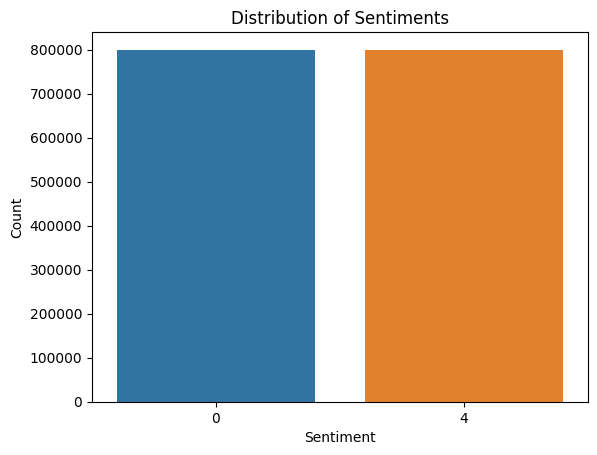

In [ ]:
sns.countplot(data=train_data, x='sentiment')

# Add labels and title
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments')

# Show the plot
plt.show()

O Gráfico acima indica a quantifdade de sentimentos negativos (Classe 0) e positivos (Classe 4) da base de dados de treinamento, demonstrando não estar desbalanceada já que possui a amesma quantidadde para cada sentimento.

In [ ]:
test_data = pd.read_csv("/content/trainingandtestdata/test.csv",
    header=None,
    names=cols,
    engine="python",
    encoding="latin1"
)

In [ ]:
test_data.head()

,sentiment,id,date,query,user,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


In [ ]:
test_data.shape

(498, 6)

In [ ]:
test_data.sentiment.unique()

array([4, 0, 2])

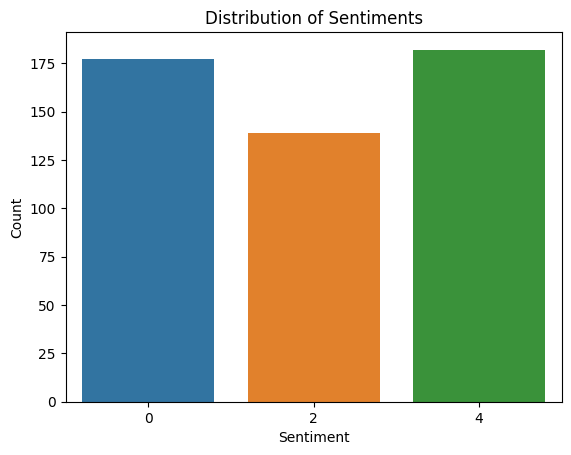

In [ ]:
sns.countplot(data=test_data, x='sentiment')

# Add labels and title
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments')

# Show the plot
plt.show()

O Gráfico acima indica a quantidade de sentimentos positivos (Classe 4), neutros (Classe 2) e negativos (Classe 0) a base de teste possui.


##2.2.Pré-processamento

###2.2.1.Limpeza

In [ ]:
data = train_data

In [ ]:
data.drop(['id', 'date', 'query', 'user'], axis = 1, inplace=True)

In [ ]:
data.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [ ]:
X = data.iloc[:, 1].values

In [ ]:
X

array(["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D",
       "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!",
       '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds',
       ..., 'Are you ready for your MoJo Makeover? Ask me for details ',
       'Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur ',
       'happy #charitytuesday @theNSPCC @SparksCharity @SpeakingUpH4H '],
      dtype=object)

In [ ]:
X.shape

(1600000,)

In [ ]:
type(X)

numpy.ndarray

In [ ]:
y = data.iloc[:, 0].values
y

array([0, 0, 0, ..., 4, 4, 4])

In [ ]:
from sklearn.model_selection import train_test_split
X, _, y, _ = train_test_split(X, y, test_size = 0.85, stratify = y)

In [ ]:
X.shape

(240000,)

In [ ]:
y.shape

(240000,)

In [ ]:
unique, counts = np.unique(y, return_counts=True)
unique, counts

(array([0, 4]), array([120000, 120000]))

In [ ]:
def clean_tweets(tweet):
  tweet = BeautifulSoup(tweet, 'lxml').get_text()
  tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet)
  tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet)
  tweet = re.sub(r"[^a-zA-Z.!?]", ' ', tweet)
  tweet = re.sub(r" +", ' ', tweet)
  return tweet

In [ ]:
text = "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  2 You shoulda got David Carr of Third Day to do it. ;D"

In [ ]:
text = clean_tweets(text)
text

' Awww that s a bummer. You shoulda got David Carr of Third Day to do it. D'

In [ ]:
nlp = sp.load('en_core_web_sm')
nlp

In [ ]:
stop_words = sp.lang.en.STOP_WORDS

In [ ]:
print(stop_words)

{'when', 'neither', 'thereby', 'besides', 'could', 'would', 'side', 'nowhere', 'be', 'well', 'nevertheless', 'fifteen', 'whither', 'not', 'thru', 'behind', 'due', 'may', 'thereupon', 'part', '’re', 'as', 'even', 'name', 'up', 'seeming', 'own', 'those', 'who', '’s', 'never', 'else', 'above', 'towards', 'except', 'our', 'somewhere', 'latter', 'although', 'four', 'seems', 'everything', 'further', 'unless', 'here', 'bottom', 'into', 'each', 'anyhow', 'however', 'to', 'am', 'beside', 'around', 'somehow', 'if', "n't", 'anything', 'whether', 'see', 'whoever', 'less', "'ll", '‘ll', 'at', 'between', 'without', 'their', 'full', 'of', 'though', 'rather', 'whenever', 'put', 'these', 'several', 'yet', 'once', 'already', 'whereby', 'does', 'yourself', 'seemed', 'among', 'anyway', 'quite', 'becomes', 'his', 'now', "'m", 'herein', 'herself', 'do', 'nine', 'six', '‘m', 'third', 'are', 'the', 'will', 'me', 'ours', 'against', 'sometime', 'few', '‘re', 'regarding', 'take', 'any', 'every', 'must', 'n‘t', '

In [ ]:
len(stop_words)

326

In [ ]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
def clean_tweets2(tweet):
  tweet = tweet.lower()
  document = nlp(tweet)

  words = []
  for token in document:
    words.append(token.text)

  words = [word for word in words if word not in stop_words and word not in string.punctuation]
  words = ' '.join([str(element) for element in words])

  return words

In [ ]:
# Awww that's a bummer. You shoulda got David Carr of Third Day to do it. D"

In [ ]:
text2 = clean_tweets2(text)
text2

'  awww s bummer shoulda got david carr day d'

In [ ]:
data_clean = [clean_tweets2(clean_tweets(tweet)) for tweet in X]

In [ ]:
for _ in range(10):
  print(data_clean[random.randint(0, len(data_clean) - 1)])

  aww ... wish concert m huge fan
waiting holidays
  .... don t know don t think able thank
glad got coach today makes transition easier
  haha yuu run ppl courtneys spits washes mouth wiff soap exspecially va
  ct thanks yesterdays follow friday
speaking exam french tomorrow start learning
think need trip doctors chest infection .. booo
  oh bites m sorry bb
  m ur father nt m creepy fuck s cute


In [ ]:
data_labels = y

In [ ]:
data_labels[data_labels == 4] = 1

In [ ]:
data_labels

array([1, 1, 1, ..., 0, 1, 1])

In [ ]:
np.unique(data_labels)

array([0, 1])

###2.2.2.Tokenização

In [ ]:
2**16

65536

In [ ]:
import math
math.pow(2, 16)

65536.0

In [ ]:
#tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(data_clean, target_vocab_size=2**16)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(data_clean, target_vocab_size=2**16)

In [ ]:
tokenizer.vocab_size

52764

In [ ]:
print(tokenizer.subwords)

['  ', 's_', 'm_', 't_', ' ... ', 'good_', ' .. ', 'like_', 'got_', 'day_', 'going_', 'nt_', 'love_', 'u_', 'don_', ' ...', 'work_', 'today_', 'time_', 'know_', 'new_', 'll_', 'want_', 'think_', 'oh_', 'lol_', 'need_', 'night_', 'thanks_', 'hope_', 've_', 'home_', 'great_', 'miss_', 'feel_', 'd_', ' .... ', 'na_', 'day', 'wish_', 'morning_', 'lol', 'twitter_', 'gon_', 'today', 'getting_', 'bad_', 'happy_', 'watching_', 'haha_', 'tomorrow_', 'sorry_', 'didn_', ' ..', 'way_', 'come_', 'nice_', 'fun_', 'sad_', 'yeah_', 'sleep_', 'work', 'n_', 'wait_', 'right_', 'hate_', 'people_', 'hey_', 'bed_', 'better_', 'little_', 'tonight_', 'school_', 'yes_', 'having_', 'y_', 'long_', 'wanna_', 'week_', 'days_', 'time', 'let_', 'best_', 'thank_', 'won_', 'feeling_', 'watch_', 'ok_', 'awesome_', 'working_', 'e_', 'o_', 'tomorrow', 'sure_', 'looking_', 'find_', 'ur_', 'r_', 'went_', 'night', 'ready_', 'good', 'trying_', 'tired_', 'look_', 'man_', 'pretty_', 'thing_', 'love', 'maybe_', 'life_', 'weeken

In [ ]:
ids = tokenizer.encode('i am happy')
ids

[254, 3736, 389]

In [ ]:
text = tokenizer.decode(ids)
text

'i am happy'

In [ ]:
data_inputs = [tokenizer.encode(sentence) for sentence in data_clean]

In [ ]:
for _ in range(10):
  print(data_inputs[random.randint(0, len(data_inputs) - 1)])

[32, 1157]
[1, 248, 6276]
[435, 221, 4446, 473, 63, 212, 63, 1519, 55, 685, 81]
[333, 12, 17094, 82, 700, 269, 3, 1134, 2125, 2279, 52617]
[1, 366, 10659, 123, 12463, 2713, 37, 215, 19, 1396]
[1, 4180, 9, 11047, 424, 18, 910, 9, 1744, 432, 302, 52623]
[1, 24, 13860, 48250, 52540, 7796, 901, 2959, 108, 689]
[1057, 4, 205, 5, 3292, 904]
[1, 6, 41, 98, 14, 75, 1145, 116, 266, 353, 6140, 98, 9340, 14, 1912, 186]
[6, 41, 277, 119, 30, 3135, 10282]


###2.2.3.Padding

In [ ]:
max_len = max([len(sentence) for sentence in data_inputs])
max_len

61

In [ ]:
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs,
                                                            value = 0,
                                                            padding = 'post',
                                                            maxlen=max_len)

In [ ]:
for _ in range(10):
  print(data_inputs[random.randint(0, len(data_inputs) - 1)])

[  25  175 4545   24  915    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
[   1   94 8475    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
[   1   31  149 2146   22 6765    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
[   1   29   10   26 1110    0    0    0    0    0    0    0    0  

###2.2.4.Divisão da base de dados em treinamento e teste



In [ ]:
train_inputs, test_inputs, train_labels, test_labels = train_test_split(data_inputs,
                                                                        data_labels,
                                                                        test_size=0.3,
                                                                        stratify = data_labels)

In [ ]:
train_inputs[0]

array([    1,    10,   845,   187,  2081,     5,  4128, 16273,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0], dtype=int32)

In [ ]:
train_inputs.shape

(168000, 61)

In [ ]:
train_labels.shape

(168000,)

In [ ]:
test_inputs.shape

(72000, 61)

In [ ]:
test_labels.shape

(72000,)

#3.Construção do modelo

In [ ]:
class DCNN(tf.keras.Model):

  def __init__(self,
               vocab_size,
               emb_dim=128,
               nb_filters=50,
               ffn_units=512,
               nb_classes=2,
               dropout_rate=0.1,
               training=True,
               name="dcnn"):
    super(DCNN, self).__init__(name=name)

    self.embedding = layers.Embedding(vocab_size, emb_dim)

    self.bigram = layers.Conv1D(filters=nb_filters, kernel_size=2, padding='same', activation='relu')

    self.trigram = layers.Conv1D(filters=nb_filters, kernel_size=3, padding='same', activation='relu')

    self.fourgram = layers.Conv1D(filters=nb_filters, kernel_size=4, padding='same', activation='relu')

    self.pool = layers.GlobalMaxPool1D()

    self.dense_1 = layers.Dense(units = ffn_units, activation = 'relu')
    self.dropout = layers.Dropout(rate = dropout_rate)
    if nb_classes == 2:
      self.last_dense = layers.Dense(units = 1, activation = 'sigmoid')
    else:
      self.last_dense = layers.Dense(units = nb_classes, activation = 'softmax')

  def call(self, inputs, training):
    x = self.embedding(inputs)
    x_1 = self.bigram(x)
    x_1 = self.pool(x_1)
    x_2 = self.trigram(x)
    x_2 = self.pool(x_2)
    x_3 = self.fourgram(x)
    x_3 = self.pool(x_3)

    merged = tf.concat([x_1, x_2, x_3], axis = -1) # (batch_size, 3 * nb_filters)
    merged = self.dense_1(merged)
    merged = self.dropout(merged, training)
    output = self.last_dense(merged)

    return output

4.Treinamento

##3.1.Configuração dos parâmetros

In [ ]:
vocab_size = tokenizer.vocab_size
vocab_size

52764

In [ ]:
emb_dim = 200
nb_filters = 100
ffn_units = 256
batch_size = 64
nb_classes = len(set(train_labels))
nb_classes

2

In [ ]:
dropout_rate = 0.2
nb_epochs = 5

###3.2.Treinamento

In [ ]:
Dcnn = DCNN(vocab_size=vocab_size, emb_dim=emb_dim, nb_filters=nb_filters,
            ffn_units=ffn_units, nb_classes=nb_classes, dropout_rate=dropout_rate)

In [ ]:
if nb_classes == 2:
  Dcnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
else:
  Dcnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
checkpoint_path = "./"
ckpt = tf.train.Checkpoint(Dcnn=Dcnn)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored')

In [ ]:
history = Dcnn.fit(train_inputs, train_labels,
                   batch_size = batch_size,
                   epochs = nb_epochs,
                   verbose = 1,
                   validation_split = 0.10)
ckpt_manager.save()

Epoch 1/5
2363/2363 [==============================] - 86s 31ms/step - loss: 0.5025 - accuracy: 0.7511 - val_loss: 0.4689 - val_accuracy: 0.7791
Epoch 2/5
2363/2363 [==============================] - 29s 12ms/step - loss: 0.3637 - accuracy: 0.8387 - val_loss: 0.5152 - val_accuracy: 0.7646
Epoch 3/5
2363/2363 [==============================] - 28s 12ms/step - loss: 0.1931 - accuracy: 0.9197 - val_loss: 0.6783 - val_accuracy: 0.7478
Epoch 4/5
2363/2363 [==============================] - 27s 11ms/step - loss: 0.1029 - accuracy: 0.9581 - val_loss: 1.0747 - val_accuracy: 0.7390
Epoch 5/5
2363/2363 [==============================] - 26s 11ms/step - loss: 0.0699 - accuracy: 0.9713 - val_loss: 1.1869 - val_accuracy: 0.7270


'./ckpt-1'

#5.Avaliação do modelo

##5.1.Avaliação

In [ ]:
results = Dcnn.evaluate(test_inputs, test_labels, batch_size=batch_size)
print(results)

1125/1125 [==============================] - 5s 4ms/step - loss: 1.1923 - accuracy: 0.7259
[1.1922719478607178, 0.725944459438324]


In [ ]:
y_pred_test = Dcnn.predict(test_inputs)

2250/2250 [==============================] - 5s 2ms/step


In [ ]:
y_pred_test

array([[1.4606160e-08],
       [8.4725153e-01],
       [9.9981874e-01],
       ...,
       [1.8367923e-06],
       [9.9990928e-01],
       [1.0000000e+00]], dtype=float32)

In [ ]:
y_pred_test = (y_pred_test > 0.5)

In [ ]:
y_pred_test

array([[False],
       [ True],
       [ True],
       ...,
       [False],
       [ True],
       [ True]])

In [ ]:
test_labels

array([0, 0, 1, ..., 0, 1, 1])

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, y_pred_test)
cm

array([[26677,  9323],
       [10409, 25591]])

<Axes: >

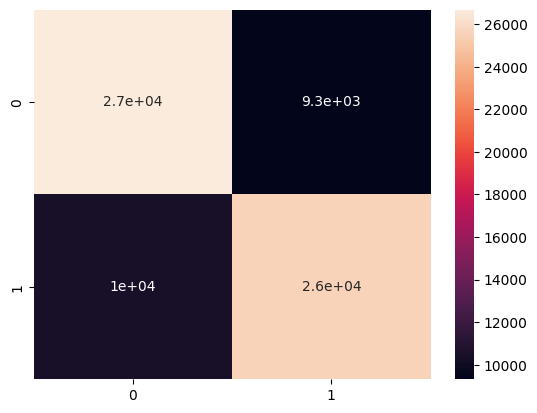

In [ ]:
sns.heatmap(cm, annot=True)

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

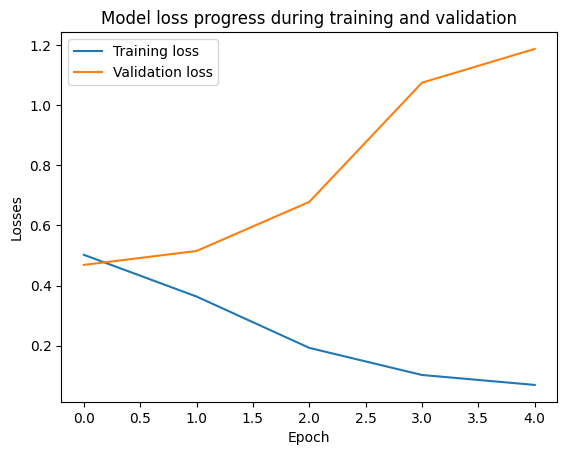

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss progress during training and validation')
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.legend(['Training loss', 'Validation loss'])

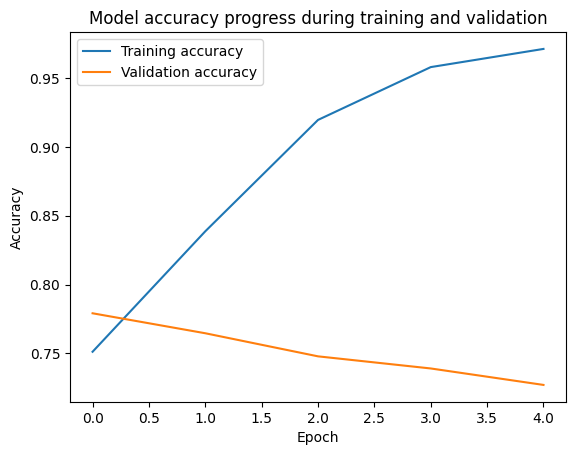

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy progress during training and validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training accuracy', 'Validation accuracy'])

##5.2.Previsões

In [ ]:
text = 'i hate you'
text = tokenizer.encode(text)
text

[254, 66, 2819]

In [ ]:
Dcnn(np.array([text]), training=False).numpy()

array([[0.39481035]], dtype=float32)